# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [566]:
import pandas as pd
import sklearn
import sqlite3
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.compose import ColumnTransformer

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [295]:
df = pd.read_csv("../data/checker_submits.csv")
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['dayofweek'] = pd.to_datetime(df['timestamp']).dt.weekday
df.drop(["timestamp"], axis=1, inplace=True)
df['uid'] = df["uid"].astype("category")
df['labname'] = df["labname"].astype("category")
df['dayofweek'] = df["dayofweek"].astype("category")

In [296]:
ct = OneHotEncoder()
ct.fit(df[['uid', 'labname']])
ct.categories_
data = ct.transform(df[['uid', 'labname']]).toarray().astype(int)
ohe_df = pd.DataFrame(data, columns=[list(ct.categories_[0]) +  list(ct.categories_[1])][0])
data = pd.concat([df, ohe_df], axis=1).drop(['uid', 'labname'], axis=1)


In [297]:
scaler = StandardScaler()
scaler.fit(data[['numTrials', 'hour']])
data[['numTrials', 'hour']] = scaler.transform(data[['numTrials', 'hour']])
data.to_csv('../data/dayofweek.csv', index=False)
data.head()

,numTrials,hour,dayofweek,user_0,user_1,user_10,user_11,user_12,user_13,user_14,...,lab02,lab03,lab03s,lab05s,laba04,laba04s,laba05,laba06,laba06s,project1
0,-0.788667,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.756764,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.724861,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.692958,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.661055,-2.562352,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [481]:
X = data.drop(['dayofweek'], axis=1).values
X_frame = data.drop(['dayofweek'], axis=1)
y = data[['dayofweek']].values[:, 0]
logreg = LogisticRegression(random_state=21, fit_intercept=False).fit(X, y)
y_pred = logreg.predict(X)
print("Accuracy: ", sklearn.metrics.accuracy_score(y, y_pred))

Accuracy:  0.6405693950177936


In [561]:
def MostImportant(coef, names, top):
    if len(coef.shape) == 2:
        coef = abs(coef).sum(axis=0)
    top_list = {}
    for i in range(len(names)):
        top_list[names[i]] = coef[i]
    top_list = dict(sorted(top_list.items(), key=lambda item: item[1], reverse=True))
    i = 0
    keys = []
    values = []
    for k, v in top_list.items():
        keys += [k]
        values += [v]
        i += 1
        if i >= top:
            break
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(keys, values , align='center')
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Value of feature (abs(sum))')
    ax.set_title('The top n features that impact on prediction')
    fig.set_size_inches(10 , top / 2)

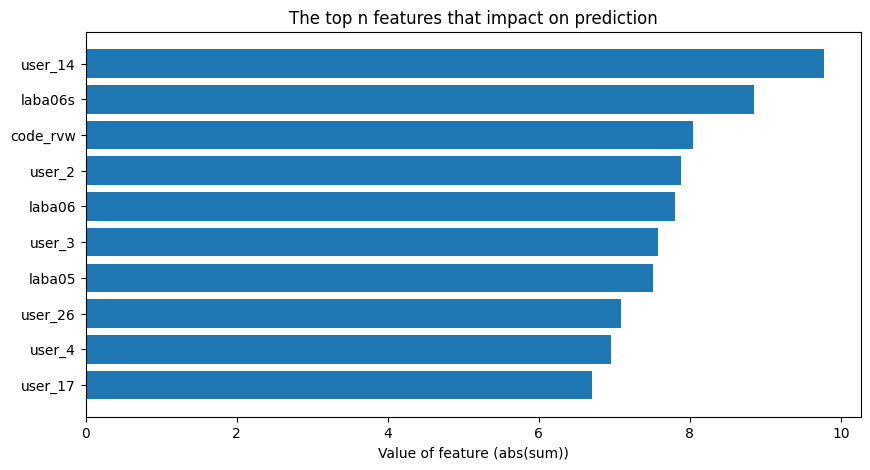

In [562]:
MostImportant(logreg.coef_, X_frame.columns.values, 10)


### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [500]:
svc_linear = SVC(random_state=21, kernel='linear', probability=True)
svc_linear.fit(X, y)
y_pred = svc_linear.predict(X)
print("Accuracy: ", sklearn.metrics.accuracy_score(y, y_pred))

Accuracy:  0.702846975088968


In [501]:
svc_polynomial = SVC(random_state=21, kernel='poly', probability=True)
svc.fit(X, y)
y_pred = svc.predict(X)
print("Accuracy: ", sklearn.metrics.accuracy_score(y, y_pred))

Accuracy:  0.8594306049822064


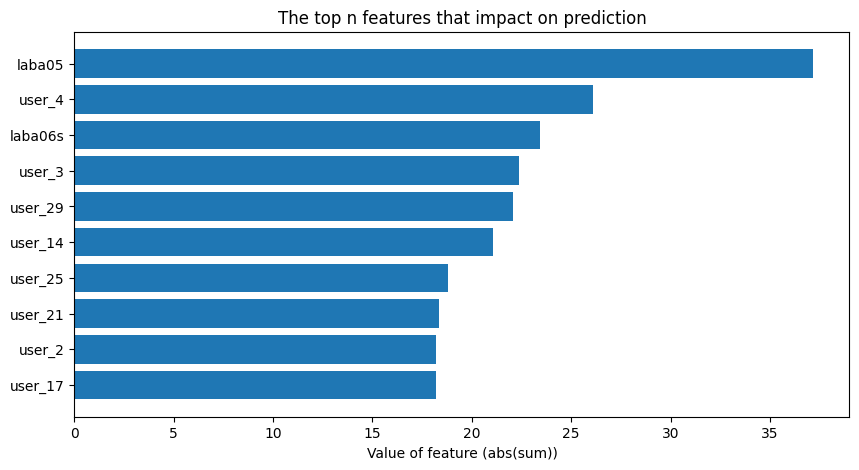

In [507]:
#clf = OneVsRestClassifier(SVC()).fit(X, y)
MostImportant(svc_linear.coef_, X_frame.columns.values, 10)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [529]:
dtc = DecisionTreeClassifier(max_depth=4, random_state=21)
dtc.fit(X,y)
y_predict = dtc.predict(X)
print("Accuracy: ", sklearn.metrics.accuracy_score(y, y_predict))

Accuracy:  0.5516014234875445


In [532]:
dtc20 = DecisionTreeClassifier(max_depth=20, random_state=21)
dtc20.fit(X,y)
y_predict = dtc20.predict(X)
print("Accuracy: ", sklearn.metrics.accuracy_score(y, y_predict))

Accuracy:  0.9869513641755635


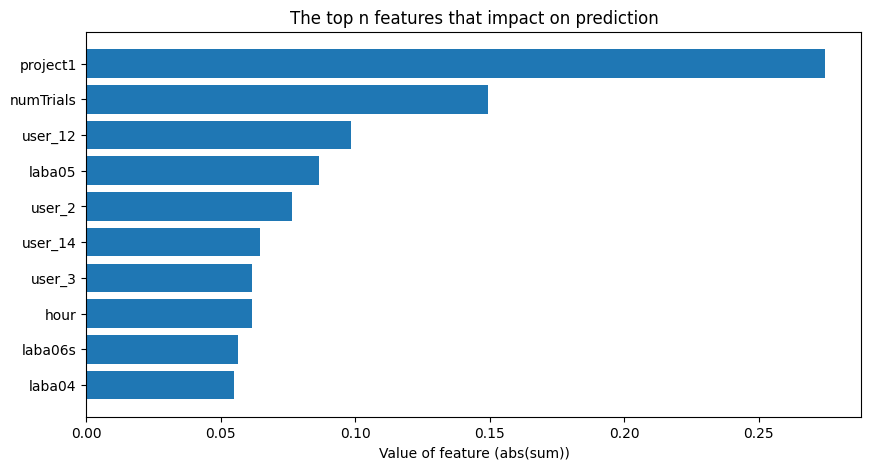

In [565]:
MostImportant(dtc.feature_importances_, X_frame.columns.values, 10)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [573]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rfc.fit(X, y)
y_predict = rfc.predict(X)
print("Accuracy: ", sklearn.metrics.accuracy_score(y, y_predict))

Accuracy:  1.0


In [577]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=21)
rfc.fit(X, y)
y_predict = rfc.predict(X)
print("Accuracy: ", sklearn.metrics.accuracy_score(y, y_predict))

Accuracy:  0.9970344009489917


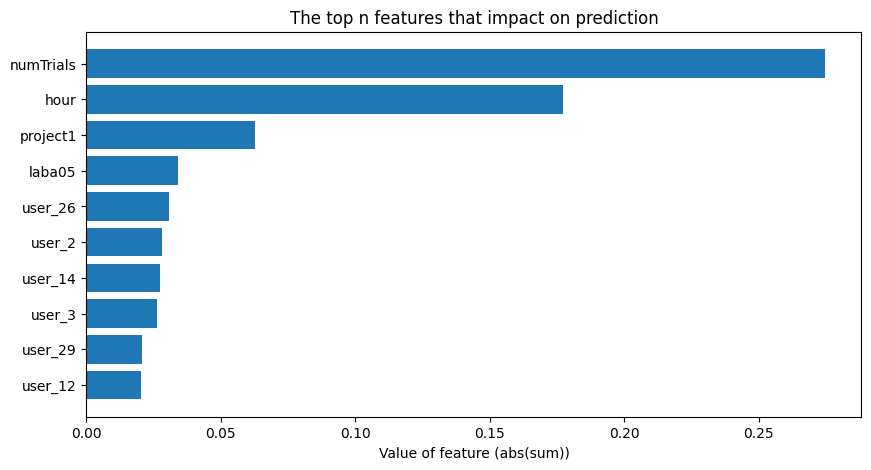

In [578]:
MostImportant(rfc.feature_importances_, X_frame.columns.values, 10)